# Lecture 21. CNN : 소규모 데이터셋 훈련

> Eunmi Kim    
 계산과학 프로그래밍 및 실습



*아래의 Tutorial 기반으로 작성*

["Transfer Learning for Computer Vision Tutorial" ](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)


---

In [4]:
from google.colab import drive
drive.mount('/content/drive') #이미지 크기 다 다른 경우 사이즈 다 동일하게 맞춰줘야함

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [3]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Current device is', device)

Current device is cuda


## 0. Load data



In [6]:
# Fix image size and normalization
data_transforms = transforms.Compose([
        transforms.Resize(256), #사이즈를 다 맞춰주는 과정
        transforms.CenterCrop(224), #가장자리 불필요한 정보 다르기
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

data_dir = '/content/drive/MyDrive/Colab Notebooks/계과프/hymenoptera_data/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
print('dataset size', dataset_sizes)
print('class names', class_names)

dataset size {'train': 244, 'val': 153}
class names ['ants', 'bees']


In [9]:
# check input image size
img, label = image_datasets['train'][0]
print(img.shape)
print(label)

torch.Size([3, 224, 224])
0


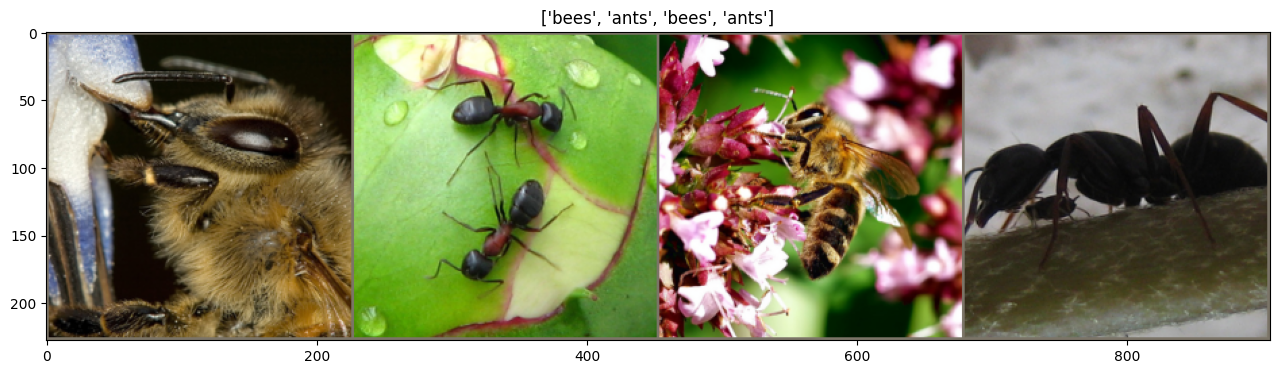

In [11]:
# Visualize a few images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 4))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

#4개 그림을 랜덤하게 가져옴

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 1. Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model
-  Plot train/validation, loss/accuracy


In [22]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    loss_list = {'train':[], 'val':[]}
    acc_list = {'train':[], 'val':[]}

    best_acc = 0.0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']: #train, validation phase 두개로 나눠짐
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.view(-1, 1).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs) >= 0.5
                    loss = criterion(outputs, labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.shape[0]
                running_corrects += torch.sum(preds == labels)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.item() / len(dataloaders[phase].dataset)

            loss_list[phase].append(epoch_loss)
            acc_list[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # save the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), '/content/drive/MyDrive/bestCNNwts.pt')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    # plot loss and accuracy
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(range(num_epochs), loss_list['train'], range(num_epochs), loss_list['val'])
    plt.legend(['Training', 'Validation'])
    plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(range(num_epochs), acc_list['train'], range(num_epochs), acc_list['val'])
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy')
    plt.show()


    # load best model weights
    model.load_state_dict(torch.load('/content/drive/MyDrive/bestCNNwts.pt'))
    return model

In [29]:
# CNN Model (2 conv layers)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 3, 224, 224)
        #    Conv     -> (?, 32, 224, 224)
        #    Pool     -> (?, 32, 112, 112)
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 32, 112, 112)
        #    Conv      ->(?, 64, 112, 112)
        #    Pool      ->(?, 64, 56, 56)
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # FC (?, 64x56x56) inputs -> (?, 1) outputs
        self.fc = nn.Linear(64*56*56, 1, bias=True)
        nn.init.kaiming_normal_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #print(out.shape) #테스트 위해서~
        out = out.view(out.size(0), -1)   # Flatten them (?, 64*56*56) for FC
        out = self.fc(out)
        return out

In [24]:
model = CNN().to(device)

In [25]:
x=torch.randn((2,3,224,224)).to(device)
model.forward(x)

torch.Size([2, 64, 56, 56])


tensor([[0.5703],
        [0.5215]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [26]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=200704, out_features=1, bias=True)
)


In [27]:
from torchsummary import summary
summary(model, (3, 224, 224)) #model과 input의 shape전달
#896=32*(3**3 +1)
#total params: 896+18496+200705=220097

torch.Size([2, 64, 56, 56])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Linear-7                    [-1, 1]         200,705
Total params: 220,097
Trainable params: 220,097
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 41.34
Params size (MB): 0.84
Estimated Total Size (MB): 42.76
----------------------------------------------------------------


Epoch 0/24
----------
train Loss: 0.9915 Acc: 0.5656
val Loss: 0.6086 Acc: 0.6471

Epoch 1/24
----------
train Loss: 0.5663 Acc: 0.7049
val Loss: 1.1649 Acc: 0.5359

Epoch 2/24
----------
train Loss: 0.5052 Acc: 0.7705
val Loss: 1.0013 Acc: 0.5686

Epoch 3/24
----------
train Loss: 0.2577 Acc: 0.9221
val Loss: 1.1413 Acc: 0.5686

Epoch 4/24
----------
train Loss: 0.2147 Acc: 0.9303
val Loss: 1.2796 Acc: 0.5882

Epoch 5/24
----------
train Loss: 0.1436 Acc: 0.9631
val Loss: 1.0126 Acc: 0.6209

Epoch 6/24
----------
train Loss: 0.0253 Acc: 1.0000
val Loss: 1.1794 Acc: 0.6209

Epoch 7/24
----------
train Loss: 0.0071 Acc: 1.0000
val Loss: 1.2074 Acc: 0.6209

Epoch 8/24
----------
train Loss: 0.0063 Acc: 1.0000
val Loss: 1.2365 Acc: 0.6144

Epoch 9/24
----------
train Loss: 0.0056 Acc: 1.0000
val Loss: 1.2560 Acc: 0.6078

Epoch 10/24
----------
train Loss: 0.0051 Acc: 1.0000
val Loss: 1.2645 Acc: 0.6209

Epoch 11/24
----------
train Loss: 0.0047 Acc: 1.0000
val Loss: 1.2804 Acc: 0.6209

Ep

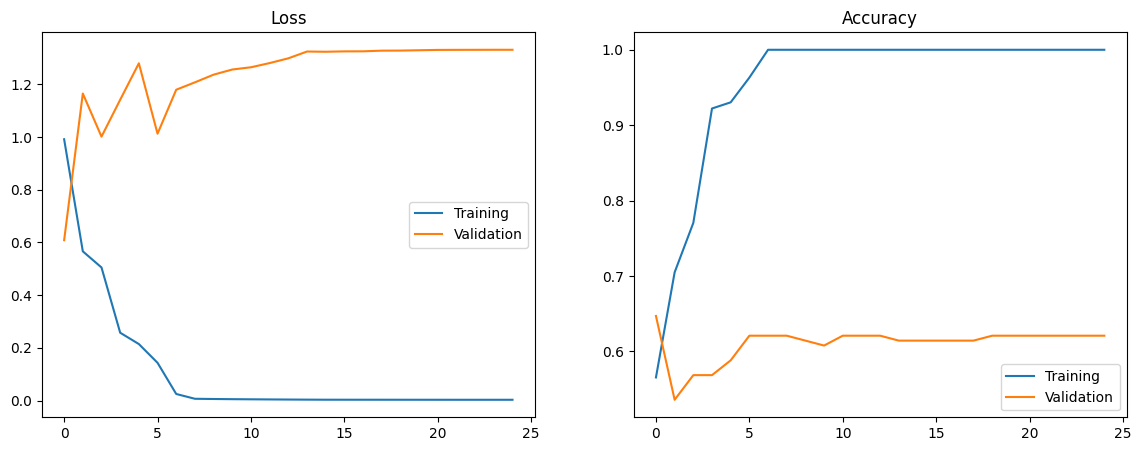

In [30]:
model = CNN().to(device)

# define loss & optimizer
criterion = nn.BCEWithLogitsLoss().to(device)    # Sigmoid is internally computed.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
step_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# train and evaluate model
model = train_model(dataloaders, model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

위 결과를 보니 train loss는 줄어들지만 validation loss가 전혀 좋아지고 있지 않음 -> overfitting 발생


-> 이미지 증식하자!

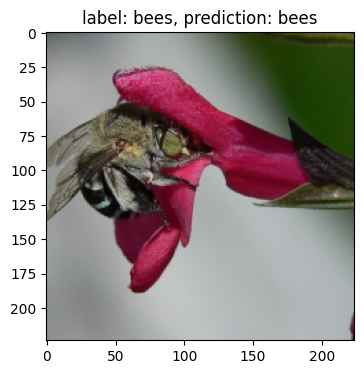

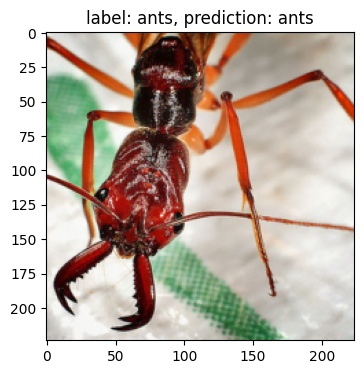

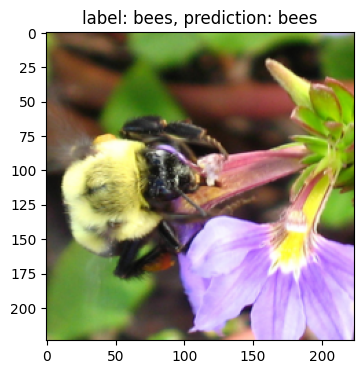

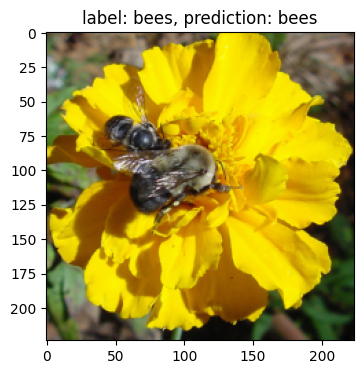

In [31]:
# visualize prediction
inputs, classes = next(iter(dataloaders['val']))

with torch.no_grad():
    inputs = inputs.to(device)

    outputs = model(inputs)
    preds = torch.sigmoid(outputs) >= 0.5


for i, input in enumerate(inputs):
    imshow(input.cpu(), title='label: %s, prediction: %s' %(class_names[classes[i]], class_names[preds[i]]))

## Data augmentation

In [36]:
# Fix image size
# Data augmentation and normalization for training
# Just normalization for validation
# overfitting을 막기 위해 데이터 증식

basic_transforms = [transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ]

#이따구로 데이터를 조금씩 변형해보장~~
data_aug = [transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomRotation(degrees=(-20, 20)),
            transforms.RandomAffine(degrees=(-20, 20), translate=(0.1, 0.2))
            ]

data_aug += basic_transforms

data_dir = '/content/drive/MyDrive/Colab Notebooks/계과프/hymenoptera_data/hymenoptera_data'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                     transforms.Compose(basic_transforms))


train_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                         transforms.Compose(data_aug))

val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                              transforms.Compose(basic_transforms))

aug_image_datasets = {'train': torch.utils.data.ConcatDataset([train_dataset, train_dataset_aug]),
                      'val': val_dataset}  #ConcatDataset를 통해 데이터 셋을 붙임

In [37]:
aug_dataloaders = {x: torch.utils.data.DataLoader(aug_image_datasets[x], batch_size=4, shuffle=True)
                   for x in ['train', 'val']}
aug_dataset_sizes = {x: len(aug_image_datasets[x]) for x in ['train', 'val']}
aug_class_names = aug_image_datasets['val'].classes

print('dataset size', aug_dataset_sizes)
print('class names', aug_class_names)

dataset size {'train': 488, 'val': 153}
class names ['ants', 'bees']


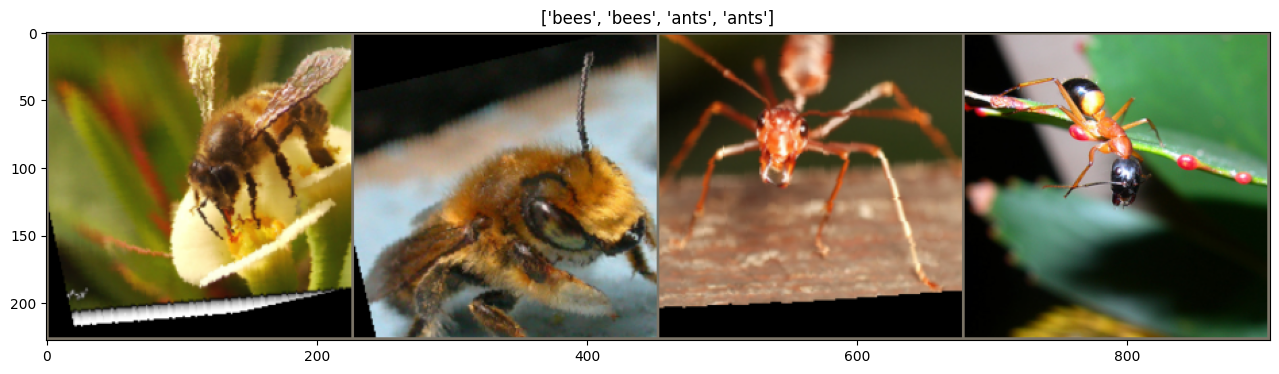

In [39]:
# Get a batch of training data
inputs, classes = next(iter(aug_dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [40]:
# deeper CNN Model
class deepCNN(nn.Module):
    def __init__(self):
        super(deepCNN, self).__init__()
        self.drop_prob = 0.5
        # L1 ImgIn shape=(?, 3, 224, 224)
        #    Conv     -> (?, 32, 224, 224)
        #    Pool     -> (?, 32, 112, 112)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 32, 112, 112)
        #    Conv      ->(?, 64, 112, 112)
        #    Pool      ->(?, 64, 56, 56)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=self.drop_prob))
        # L3 ImgIn shape=(?, 64, 56, 56)
        #    Conv      ->(?, 128, 56, 56)
        #    Pool      ->(?, 128, 28, 28)
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # L4 FC (?, 128x28x28) inputs -> (?, 512) outputs
        self.fc1 = nn.Linear(128*28*28, 512, bias=True)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=self.drop_prob))
        # L5 Final FC (?, 512) inputs -> (?, 1) outputs
        self.fc2 = nn.Linear(512, 1, bias=True)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

Epoch 0/24
----------
train Loss: 0.8443 Acc: 0.5881
val Loss: 0.7739 Acc: 0.5425

Epoch 1/24
----------
train Loss: 0.7446 Acc: 0.6393
val Loss: 0.8241 Acc: 0.5490

Epoch 2/24
----------
train Loss: 0.7752 Acc: 0.5902
val Loss: 0.7374 Acc: 0.6209

Epoch 3/24
----------
train Loss: 0.6562 Acc: 0.6496
val Loss: 0.7594 Acc: 0.5817

Epoch 4/24
----------
train Loss: 0.6619 Acc: 0.6824
val Loss: 0.6607 Acc: 0.6471

Epoch 5/24
----------
train Loss: 0.5944 Acc: 0.7275
val Loss: 0.7106 Acc: 0.5882

Epoch 6/24
----------
train Loss: 0.5590 Acc: 0.7295
val Loss: 0.7023 Acc: 0.6405

Epoch 7/24
----------
train Loss: 0.5553 Acc: 0.7090
val Loss: 0.6639 Acc: 0.6405

Epoch 8/24
----------
train Loss: 0.5763 Acc: 0.7029
val Loss: 0.7156 Acc: 0.6275

Epoch 9/24
----------
train Loss: 0.5758 Acc: 0.6865
val Loss: 0.7413 Acc: 0.6144

Epoch 10/24
----------
train Loss: 0.5773 Acc: 0.6947
val Loss: 0.6751 Acc: 0.6601

Epoch 11/24
----------
train Loss: 0.6203 Acc: 0.6578
val Loss: 0.7527 Acc: 0.6144

Ep

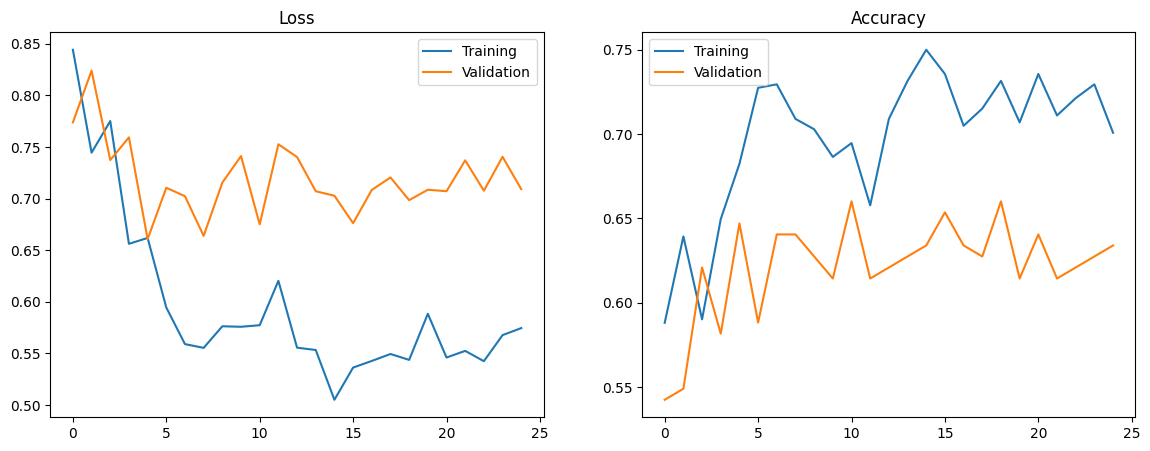

In [41]:
deep_model = deepCNN().to(device)

# define loss & optimizer
criterion = nn.BCEWithLogitsLoss().to(device)    # Sigmoid is internally computed.
optimizer_d = optim.Adam(deep_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
step_lr_scheduler_d = optim.lr_scheduler.StepLR(optimizer_d, step_size=4, gamma=0.1)

# train and evaluate model
deep_model = train_model(aug_dataloaders, deep_model, criterion, optimizer_d,
                         step_lr_scheduler_d, num_epochs=25)

흠.. train도 그다지여서 learning rate를 조절해보면 ㄱㅊ을 거라고 생각 가능


-> 해결 by transfer learning!! (다음시간에~~)

## 3. Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)
print(model_ft)

In [ ]:
model_ft.classifier[-1].in_features

In [ ]:
num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, 1)

model_ft = model_ft.to(device)

In [ ]:
summary(model_ft, (3, 224,224))

In [ ]:
print(model_ft)

In [ ]:
criterion = nn.BCEWithLogitsLoss().to(device)    # Sigmoid is internally computed.

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
step_lr_scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Training
model_ft = train_model(dataloaders, model_ft, criterion, optimizer_ft,
                       step_lr_scheduler_ft, num_epochs=15)

## 4. Transfer Learning (use ConvNet as fixed feature extractor)
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
<https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>.




### VGG

In [ ]:
model_tl = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

for param in model_tl.parameters():
    param.requires_grad = False

num_ftrs = model_tl.classifier[-1].in_features
model_tl.classifier[-1] = nn.Linear(num_ftrs, 1)

model_tl = model_tl.to(device)

In [ ]:
summary(model_tl, (3, 224, 224))

In [ ]:
# define loss & optimizer
criterion = nn.BCEWithLogitsLoss().to(device)    # Sigmoid is internally computed.

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_tl = optim.SGD(model_tl.classifier[-1].parameters(), lr=0.0002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
step_lr_scheduler_tl = optim.lr_scheduler.StepLR(optimizer_tl, step_size=7, gamma=0.1)

# Training
model_tl = train_model(dataloaders, model_tl, criterion, optimizer_tl,
                        step_lr_scheduler_tl, num_epochs=15)

### ResNet

In [ ]:
model_resnet = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)
print(model_resnet)

In [ ]:
model_resnet.fc

Test
--

In [ ]:
from PIL import Image

test_img = Image.open('/content/drive/MyDrive/hymenoptera_data/test2.jpg')

test_input = data_transforms(test_img)

print(test_input.shape)

In [ ]:
test_input = test_input.view(1, 3, 224, 224)
print(test_input.shape)

In [ ]:
model_list = [model, deep_model, model_ft, model_tl]


for m in model_list:
    m.eval()
    test_out = m(test_input.to(device))
    pred=torch.sigmoid(test_out) >= 0.5
    print(class_names[int(pred)])

In [ ]:
plt.imshow(np.array(test_img))

In [ ]:
imshow(data_transforms(test_img))